In [1]:
import statsmodels.api as sm
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

/media/pub/coudray/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
path = "Data/ukcp09_gridded-land-obs-daily_timeseries_mean-temperature_000000E_500000N_19600101-20161231.csv"
data = pd.read_csv(path, header=[0,1], index_col=0, parse_dates=True)

In [3]:
dates_to_remove = [datetime.date(datetime.strptime(str(y)+"-02-29", '%Y-%m-%d')) for y in range(1960, 2017, 4)]
data = data.drop(dates_to_remove)
series = data["22500"]["547500"]

In [4]:
series.head()

1960-01-01    6.20
1960-01-02    4.53
1960-01-03    8.48
1960-01-04    7.02
1960-01-05    2.49
Name: 547500, dtype: float64

In [5]:
decomp_freq = 365

In [6]:
res = sm.tsa.seasonal_decompose(series, freq=decomp_freq, model='additive')

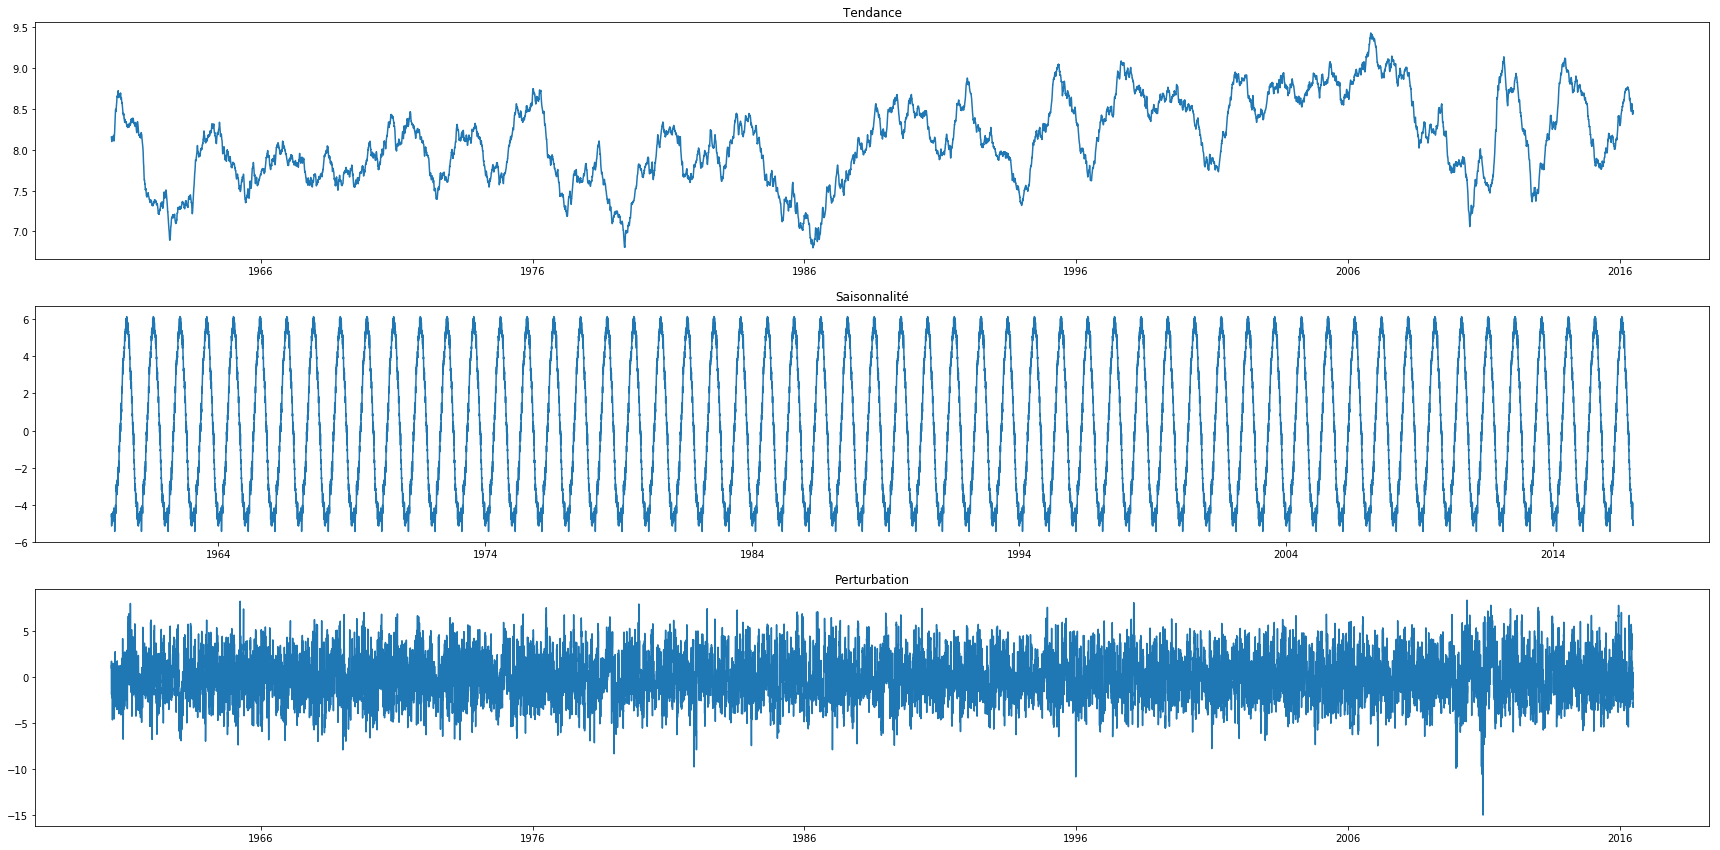

In [160]:
plt.figure(figsize=(30,20))
plt.subplot(411)
plt.plot(res.trend)
plt.title("Tendance")
plt.subplot(412)
plt.plot(res.seasonal)
plt.title("Saisonnalité")
plt.subplot(413)
plt.plot(res.resid)
plt.title("Perturbation")
plt.show()

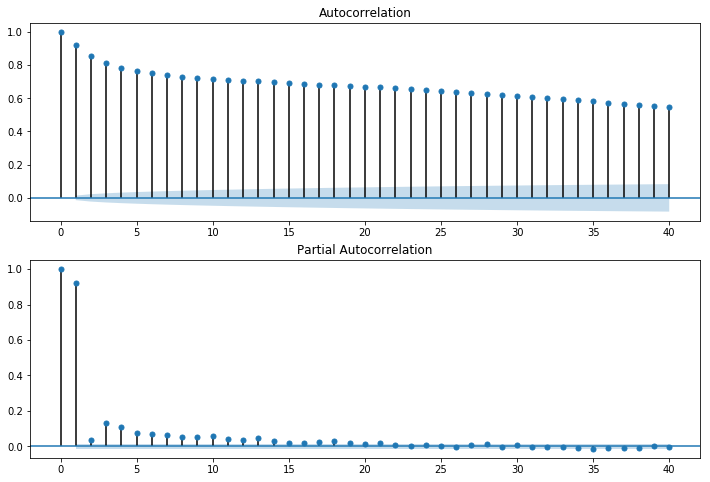

In [8]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(series.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(series, lags=40, ax=ax2)

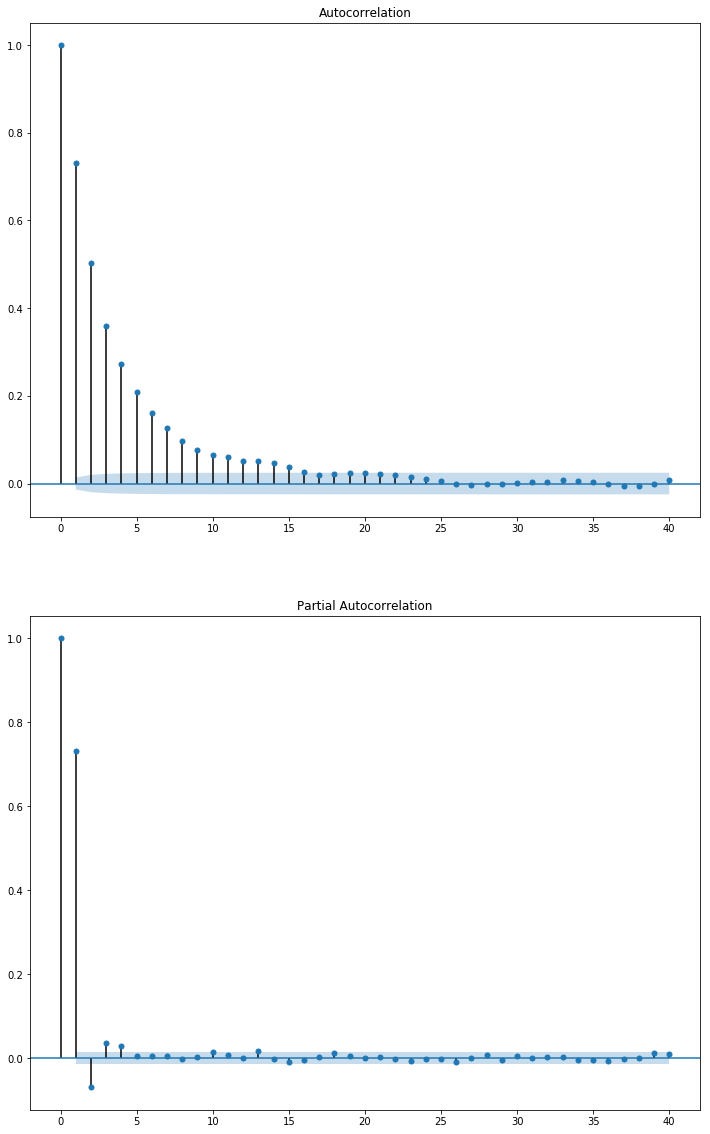

In [9]:
resid = res.resid.dropna()
fig = plt.figure(figsize=(12,20))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid.squeeze(), lags=40, ax=ax1, alpha=0.05)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid, lags=40, ax=ax2)

Observations :
+ decroissance exponentielle de la fonction d'autocorrélation
+ autocorrélation partielle nulle pour h > 4

In [10]:
acf, conf_acf = sm.tsa.acf(resid, alpha=0.05)

Méthode du coin pour estimer p,q (choix d'un modèle ARMA)

In [11]:
def adjugate(M):
    A = np.zeros(M.shape)
    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            E1 = [k for k in range(M.shape[0]) if k!=i]
            E2 = [k for k in range(M.shape[0]) if k!=j]
            if len(E1)==0:
                A[i,j] = 1
            else:
                A[i,j] = (-1)**(i+j)*np.linalg.det(M[np.array(E1)][:,np.array(E2)])
    return A
def delta(acf, j, k):
    M = np.array([acf[k+1-i:k+j+2-i] for i in range(j+1)])
    M = np.zeros((j+1,j+1))
    for i in range(j+1):
        for l in range(j+1):
            M[i,l] = acf[abs(k+1-i+l)]
    A = adjugate(M)
    return np.linalg.det(M), 1.96*(1+2*np.sum(acf[max(0,k+1-j):k+j+3]))*np.trace(A)**2

In [12]:
def coin(acf, maxp = 10, maxq = 10):
    D = np.zeros((maxp, maxq))
    C = np.zeros((maxp, maxq))
    for i in range(maxp):
        for j in range(maxq):
            d, conf = delta(acf, i, j)
            D[i,j] = round(d,4)
            C[i,j] = round(conf/np.sqrt(20441),4)
    return C, D

In [13]:
M = np.diag([1,2,3])
print(M)
M[np.array([1,2])][:,[1,2]]

[[1 0 0]
 [0 2 0]
 [0 0 3]]


array([[2, 0],
       [0, 3]])

In [14]:
adjugate(M)

array([[ 6., -0.,  0.],
       [-0.,  3., -0.],
       [ 0., -0.,  2.]])

In [15]:
C, D = coin(acf)

Ok, mais à quelle valeur comparer pour test de nullité? Cours pas très clair... cf p 169 -> comment estimer la variance ?

A partir de la deuxième ligne, les coefficients semblent négligeables. On s'oriente donc vers un modèle de type AR(p) avec p = 6 dans un premier temps (on prend large exprès)

In [146]:
model1 = sm.tsa.ARMA(resid, (6,0))
result1 = model1.fit(disp=False)

/media/pub/coudray/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/media/pub/coudray/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


In [147]:
result1.params

const          -0.004743
ar.L1.547500    0.783436
ar.L2.547500   -0.095187
ar.L3.547500    0.014469
ar.L4.547500    0.025263
ar.L5.547500   -0.000317
ar.L6.547500    0.006284
dtype: float64

In [148]:
confidence = result1.conf_int(alpha=0.05)
print((confidence[1]-confidence[0])/2)

/media/pub/coudray/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/media/pub/coudray/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


const           0.084858
ar.L1.547500    0.013709
ar.L2.547500    0.017417
ar.L3.547500    0.017462
ar.L4.547500    0.017463
ar.L5.547500    0.017417
ar.L6.547500    0.013710
dtype: float64


In [149]:
result1.pvalues

const           9.127710e-01
ar.L1.547500    0.000000e+00
ar.L2.547500    1.055784e-26
ar.L3.547500    1.043832e-01
ar.L4.547500    4.579769e-03
ar.L5.547500    9.715697e-01
ar.L6.547500    3.690182e-01
dtype: float64

In [150]:
model2 = sm.tsa.ARMA(resid, (4,0))
result2 = model2.fit(disp=False)

/media/pub/coudray/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/media/pub/coudray/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


In [151]:
result2.params

const          -0.004728
ar.L1.547500    0.783594
ar.L2.547500   -0.094966
ar.L3.547500    0.014123
ar.L4.547500    0.028276
dtype: float64

In [152]:
confidence2 = result2.conf_int(alpha=0.05)
print((confidence2[1]-confidence2[0])/2)

/media/pub/coudray/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/media/pub/coudray/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


const           0.083940
ar.L1.547500    0.013704
ar.L2.547500    0.017413
ar.L3.547500    0.017413
ar.L4.547500    0.013704
dtype: float64


/media/pub/coudray/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


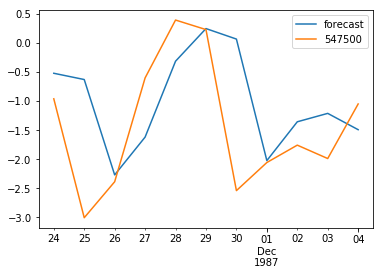

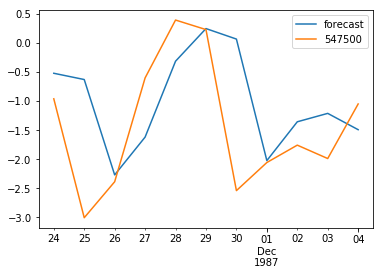

In [155]:
result2.plot_predict(10000,10010)

/media/pub/coudray/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


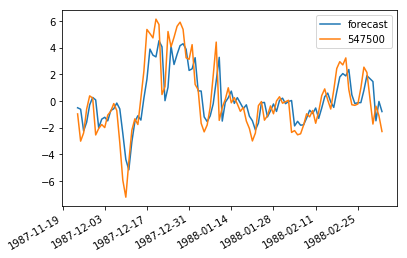

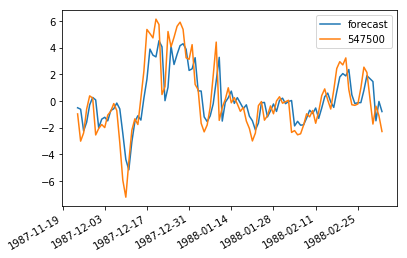

In [145]:
result1.plot_predict(10000,10100)

In [156]:
sm.tsa.acf(result1.resid)

/media/pub/coudray/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


array([ 1.00000000e+00, -8.33718924e-05,  4.91264089e-05, -1.52238952e-04,
       -1.86415280e-04,  3.35664173e-04, -4.87361345e-03,  3.24597183e-03,
        7.62196061e-04, -9.58978442e-03,  2.14467648e-03,  1.05831586e-02,
       -4.67969799e-03,  1.37496268e-02,  1.41976316e-02,  5.41252846e-03,
       -3.01625377e-03, -8.07657405e-03,  2.92400569e-03,  7.11204178e-03,
        4.83839396e-03,  5.61472837e-03,  7.71423530e-03,  9.19142774e-04,
       -7.84963662e-04,  4.60828739e-03, -4.48231191e-03, -9.50519908e-03,
        3.89300517e-03, -4.70649567e-03,  1.30894850e-03,  3.77494906e-04,
       -4.30375952e-04,  6.54095681e-03,  3.99073474e-03,  2.73865241e-03,
       -3.94603652e-03, -3.66690785e-03, -9.91612431e-03, -3.04471155e-03,
        6.11486299e-03])

In [157]:
sm.tsa.acf(result2.resid)

/media/pub/coudray/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


array([ 1.00000000e+00, -1.76877986e-04, -2.82601499e-04, -5.95575927e-05,
       -2.99334145e-03, -2.16597647e-03, -3.31785602e-04,  7.09655096e-03,
        3.21119336e-03, -8.14268892e-03,  3.20079670e-03,  1.14252294e-02,
       -3.96540010e-03,  1.43680049e-02,  1.46463386e-02,  5.65053352e-03,
       -2.82654227e-03, -7.93871091e-03,  2.95736024e-03,  7.20951737e-03,
        4.96174531e-03,  5.77673082e-03,  7.87879660e-03,  9.33077193e-04,
       -7.63832184e-04,  4.67796899e-03, -4.42157815e-03, -9.40646765e-03,
        3.98513590e-03, -4.68739169e-03,  1.29706536e-03,  4.37661420e-04,
       -3.95865262e-04,  6.58979407e-03,  4.10200162e-03,  2.76472141e-03,
       -3.93965058e-03, -3.70037881e-03, -9.93648717e-03, -3.02681579e-03,
        6.16729007e-03])